# Installs & Imports

In [1]:
!pip install -q scikit-learn-extra

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import MatplotlibDeprecationWarning
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, davies_bouldin_score
from sklearn.manifold import MDS, TSNE
from sklearn_extra.cluster import KMedoids
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.signal import square
import itertools
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

# Data Generation

In [3]:
def sawtooth_wave(time, freq=1.0):
    """
    Generate a sawtooth wave.

    Parameters:
    - time (np.ndarray): Array of time points.
    - freq (float): Frequency of the sawtooth wave.

    Returns:
    - np.ndarray: Array representing the sawtooth wave.
    """
    return 2 * (time * freq / (2 * np.pi) - np.floor(0.5 + time * freq / (2 * np.pi)))

In [4]:
def generate_sample_data(n_per_cluster=10, series_length=100, sawtooth_freq_range=(1.0, 2.0), random_walk_std_range=(0.05, 0.15), include_square_wave=False):
    """
    Generate synthetic sample data with distinct patterns:
    - Sine waves with random phase shifts.
    - Sawtooth waves with random frequencies and added noise.
    - Random walks with random step sizes.
    - (Optional) Square waves with random frequencies and added noise.

    Parameters:
    - n_per_cluster (int): Number of time series per cluster.
    - series_length (int): Length of each time series.
    - sawtooth_freq_range (tuple): Range of frequencies for sawtooth waves.
    - random_walk_std_range (tuple): Range of standard deviations for random walk steps.
    - include_square_wave (bool): Whether to include square waves as an additional cluster.

    Returns:
    - list of np.ndarray: List of normalized time series.
    """
    np.random.seed(42)
    time = np.linspace(0, 4 * np.pi, series_length)
    series = []

    # Generate sine waves with random phase shifts
    for _ in range(n_per_cluster):
        phase_shift = np.random.normal(0, 0.2)
        s = np.sin(time + phase_shift)
        series.append(s)

    # Generate sawtooth waves with random frequencies and added noise
    for _ in range(n_per_cluster):
        freq = np.random.uniform(*sawtooth_freq_range)
        noise = np.random.normal(0, 0.3, series_length)
        s = sawtooth_wave(time, freq=freq) + noise
        series.append(s)

    # Generate random walks with random step sizes
    for _ in range(n_per_cluster):
        std = np.random.uniform(*random_walk_std_range)
        steps = np.random.normal(0, std, series_length)
        s = np.cumsum(steps)
        series.append(s)

    # Generate square waves with random frequencies and added noise
    if include_square_wave:
        for _ in range(n_per_cluster):
            freq = np.random.uniform(0.5, 1.5)
            noise = np.random.normal(0, 0.3, series_length)
            s = square(time * freq) + noise
            series.append(s)

    # Normalize each series
    scaler = StandardScaler()
    series = [scaler.fit_transform(s.reshape(-1, 1)).flatten() for s in series]

    return series

In [5]:
# Parameters for data generation
n_per_cluster = 10
series_length = 100
sawtooth_freq_range = (1.0, 2.0)
random_walk_std_range = (0.05, 0.15)
include_square_wave = True

In [6]:
# Generate synthetic time series data
series = generate_sample_data(
    n_per_cluster=n_per_cluster,
    series_length=series_length,
    sawtooth_freq_range=sawtooth_freq_range,
    random_walk_std_range=random_walk_std_range,
    include_square_wave=include_square_wave
)

print(f"Total number of time series: {len(series)}")

Total number of time series: 40


In [7]:
def visualize_sample_series(series_list, n_samples=3, title='Sample Time Series from Different Clusters', random_state=None):
    """
    Visualize a random sample of time series from different clusters.

    Parameters:
    - series_list (list of np.ndarray): List of time series.
    - n_samples (int): Number of samples to visualize.
    - title (str): Title of the plot.
    - random_state (int, optional): Seed for reproducibility.

    Returns:
    - None
    """
    if random_state is not None:
        np.random.seed(random_state)

    plt.figure(figsize=(15, 6))

    # Randomly select n_samples without replacement
    indices = np.random.choice(len(series_list), size=n_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.plot(series_list[idx], label=f'Series {idx+1}')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.show()

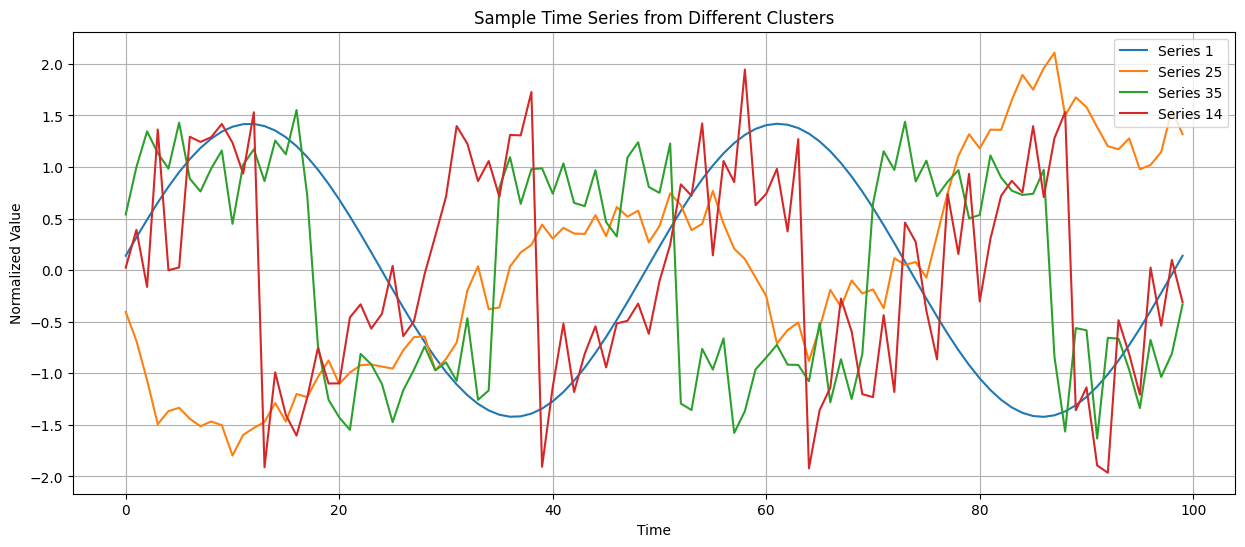

In [8]:
# Visualize some of the time series
visualize_sample_series(series, n_samples=4)

# DTW Calculation

In [9]:
def dtw_distance(s1, s2, window=None):
    """
    Compute the Dynamic Time Warping (DTW) distance between two sequences with optional window constraint.

    Parameters:
    - s1 (np.ndarray): First time series (1D array).
    - s2 (np.ndarray): Second time series (1D array).
    - window (int, optional): Maximum warping window size. Defaults to None, allowing full warping.

    Returns:
    - float: DTW distance.
    - list of tuples: Optimal warping path.

    Example:
        >>> s1 = np.array([1, 2, 3, 4, 2, 1])
        >>> s2 = np.array([1, 3, 4, 2, 1])
        >>> distance, path = dtw_distance(s1, s2)
        >>> print(distance)
        2.0
        >>> print(path)
        [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (4, 4), (5, 4)]
    """
    n, m = len(s1), len(s2)
    if window is None:
        window = max(n, m)
    else:
        window = max(window, abs(n - m))

    # Initialize the cost matrix with infinity
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    # Populate the DTW matrix with window constraints
    for i in range(1, n + 1):
        start_j = max(1, i - window)
        end_j = min(m + 1, i + window + 1)
        for j in range(start_j, end_j):
            cost = abs(s1[i - 1] - s2[j - 1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # Insertion
                dtw_matrix[i, j - 1],    # Deletion
                dtw_matrix[i - 1, j - 1] # Match
            )

    # Traceback to find the optimal path
    i, j = n, m
    path = []
    while (i > 0) and (j > 0):
        path.append((i - 1, j - 1))
        direction = np.argmin([
            dtw_matrix[i - 1, j],    # Insertion
            dtw_matrix[i, j - 1],    # Deletion
            dtw_matrix[i - 1, j - 1] # Match
        ])
        if direction == 0:
            i -= 1
        elif direction == 1:
            j -= 1
        else:  # direction == 2
            i -= 1
            j -= 1
    path.append((0, 0))
    path.reverse()

    return dtw_matrix[n, m], path

In [10]:
def compute_dtw_distance(ts1, ts2, window_size=None):
    """
    Compute DTW distance between two time series with optional window constraint.

    Parameters:
    - ts1 (np.ndarray): First time series.
    - ts2 (np.ndarray): Second time series.
    - window_size (int, optional): Maximum warping window size.

    Returns:
    - float: DTW distance.
    """
    distance, _ = dtw_distance(ts1, ts2, window=window_size)
    return distance

In [11]:
def create_dtw_distance_matrix(series_list, n_jobs=-1, window_ratio=0.25):
    """
    Create condensed DTW distance matrix using manual DTW computation and parallel processing.

    Parameters:
    - series_list (list of np.ndarray): List of time series.
    - n_jobs (int): Number of parallel jobs. -1 uses all available cores.
    - window_ratio (float): Ratio to determine Sakoe-Chiba window size.

    Returns:
    - np.ndarray: Condensed distance matrix (1D array).
    """
    n = len(series_list)
    distances = Parallel(n_jobs=n_jobs)(
        delayed(compute_dtw_distance)(
            series_list[i],
            series_list[j],
            window_size=int(max(len(series_list[i]), len(series_list[j])) * window_ratio)
        )
        for i, j in tqdm(itertools.combinations(range(n), 2), total=(n*(n-1))//2, desc="Calculating DTW distances")
    )
    return np.array(distances)

In [12]:
# Compute DTW distance matrix using manual implementation with parallel processing
dist_matrix_manual = create_dtw_distance_matrix(
    series_list=series,
    n_jobs=-1,
    window_ratio=0.25  # 25% Sakoe-Chiba window
)
print("Manual DTW distance matrix calculation completed.")

Calculating DTW distances: 100%|██████████| 780/780 [00:09<00:00, 81.53it/s]


Manual DTW distance matrix calculation completed.


# Clustering Methods

In [13]:
def hierarchical_clustering(dist_matrix, max_clusters=10, linkage_method='average'):
    """
    Perform hierarchical clustering with automatic cluster selection using silhouette scores.

    Parameters:
    - dist_matrix (np.ndarray): Condensed distance matrix.
    - max_clusters (int): Maximum number of clusters to evaluate.
    - linkage_method (str): Linkage method ('single', 'complete', 'average', 'ward').

    Returns:
    - final_clusters (np.ndarray): Array of cluster labels.
    - Z (np.ndarray): Linkage matrix.
    - best_k (int): Optimal number of clusters based on silhouette score.
    - silhouette_scores (list): List of silhouette scores for each k.
    """
    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method=linkage_method)

    # Convert condensed distance matrix to square form for silhouette_score
    square_dist = squareform(dist_matrix)

    # Find optimal number of clusters using silhouette scores
    best_k = 2
    best_score = -1
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        clusters = fcluster(Z, k, criterion='maxclust')
        sil_score = silhouette_score(square_dist, clusters, metric='precomputed')
        silhouette_scores.append(sil_score)
        if sil_score > best_score:
            best_score = sil_score
            best_k = k

    # Assign final clusters based on best_k
    final_clusters = fcluster(Z, best_k, criterion='maxclust')

    # Plot dendrogram and silhouette scores
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12.)
    plt.axhline(y=Z[-best_k, 2], c='k', ls='--', label=f'Optimal K={best_k}')
    plt.title(f'Dendrogram (Optimal K={best_k})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different K')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Optimal number of clusters based on Silhouette Score: {best_k} with Score: {best_score:.4f}")

    return final_clusters, Z, best_k, silhouette_scores

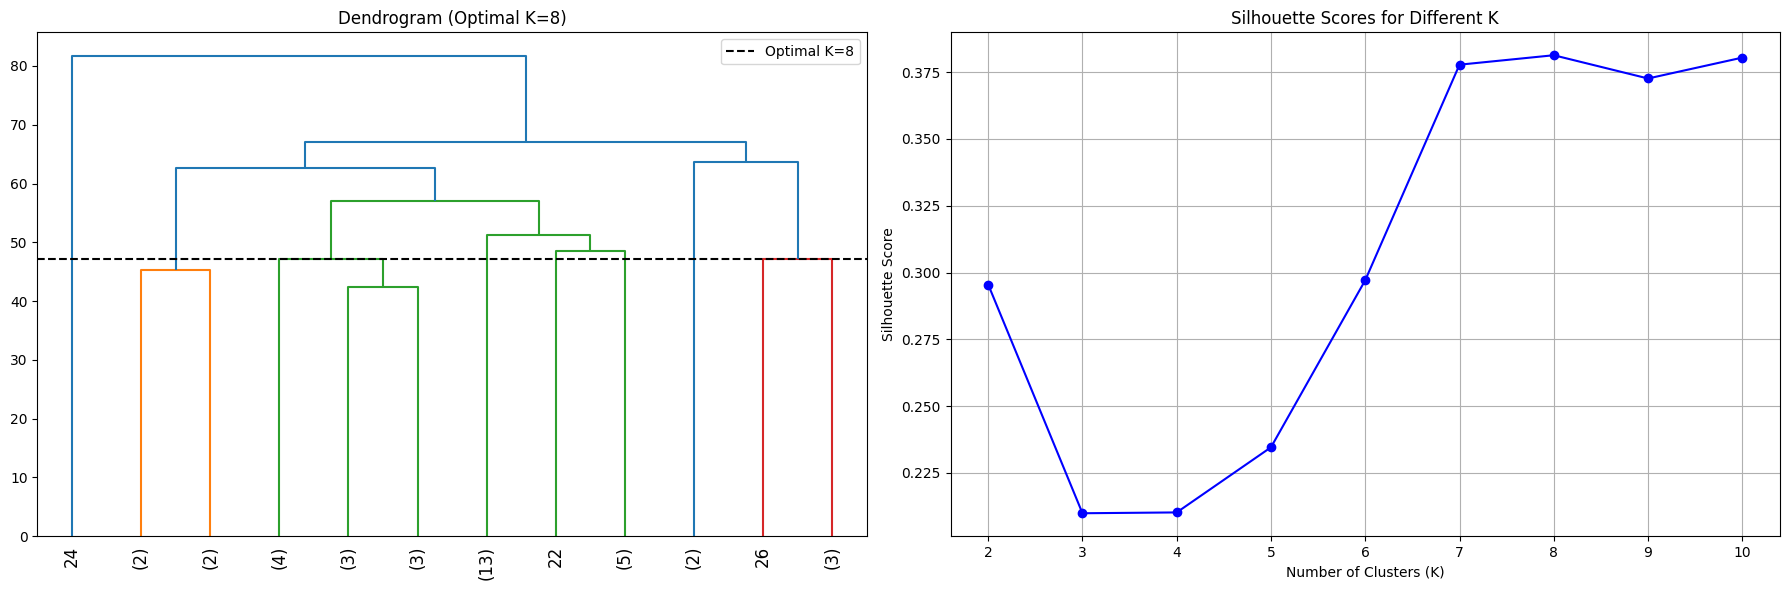

Optimal number of clusters based on Silhouette Score: 8 with Score: 0.3813


In [14]:
# Hierarchical clustering
clusters_hier_manual, Z_manual, best_k_manual, silhouette_scores_manual = hierarchical_clustering(
    dist_matrix=dist_matrix_manual,
    max_clusters=10,
    linkage_method='average'
)

In [15]:
def kmedoids_clustering(dist_matrix, n_clusters=3, max_iter=300, random_state=42):
    """
    Perform K-Medoids clustering using a precomputed DTW distance matrix.

    Parameters:
    - dist_matrix (np.ndarray): Condensed distance matrix.
    - n_clusters (int): Number of clusters.
    - max_iter (int): Maximum number of iterations.
    - random_state (int): Seed for reproducibility.

    Returns:
    - labels (np.ndarray): Cluster labels for each time series.
    - medoids (list): Indices of the medoid time series.
    """
    # Convert condensed distance matrix to square form using SciPy's squareform
    square_dist = squareform(dist_matrix)

    # Initialize and fit K-Medoids
    model = KMedoids(n_clusters=n_clusters, metric='precomputed', init='k-medoids++', max_iter=300, random_state=random_state)
    labels = model.fit_predict(square_dist)
    medoids = model.medoid_indices_

    return labels, medoids

In [16]:
# K-Medoids clustering
optimal_k_manual = best_k_manual  # Using the optimal number from hierarchical clustering
print(f"Performing K-Medoids clustering with K={optimal_k_manual}...")
clusters_kmed_manual, medoids_manual = kmedoids_clustering(
    dist_matrix=dist_matrix_manual,
    n_clusters=optimal_k_manual,
    max_iter=300,
    random_state=42
)
print(f"K-Medoids clustering completed. Medoid indices: {medoids_manual}")

Performing K-Medoids clustering with K=8...
K-Medoids clustering completed. Medoid indices: [38  5 18 14 27 25 21 20]


In [17]:
def get_medoids(series_list, medoid_indices):
    """
    Retrieve medoid time series based on their indices.

    Parameters:
    - series_list (list of np.ndarray): List of time series.
    - medoid_indices (list or np.ndarray): Indices of medoid time series.

    Returns:
    - list of np.ndarray: List of medoid time series.
    """
    return [series_list[idx] for idx in medoid_indices]

# Cluster Visualization

In [18]:
def visualize_clusters(series_list, clusters, medoids=None, title='Time Series Clusters', cmap='tab10'):
    """
    Visualize time series clusters with different colors and optionally highlight medoids.

    Parameters:
    - series_list (list of np.ndarray): List of time series.
    - clusters (np.ndarray): Array of cluster labels.
    - medoids (list, optional): List of medoid indices. Defaults to None.
    - title (str): Title of the plot.
    - cmap (str): Matplotlib colormap name.

    Returns:
    - None
    """
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    colors = get_cmap(cmap, n_clusters)

    plt.figure(figsize=(15, 4 * n_clusters))

    for idx, cluster_id in enumerate(unique_clusters):
        plt.subplot(n_clusters, 1, idx + 1)
        cluster_indices = np.where(clusters == cluster_id)[0]

        for i in cluster_indices:
            plt.plot(series_list[i], color=colors(idx), alpha=0.5, linewidth=1)

        # Highlight medoid if provided
        if medoids is not None and (cluster_id - 1) < len(medoids):
            medoid_idx = medoids[cluster_id - 1]
            plt.plot(series_list[medoid_idx], color='black', linewidth=2, label='Medoid')

        plt.title(f'Cluster {cluster_id} ({len(cluster_indices)} series)')
        if medoids is not None and (cluster_id - 1) < len(medoids):
            plt.legend()
        plt.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Visualizing hierarchical clustering results...


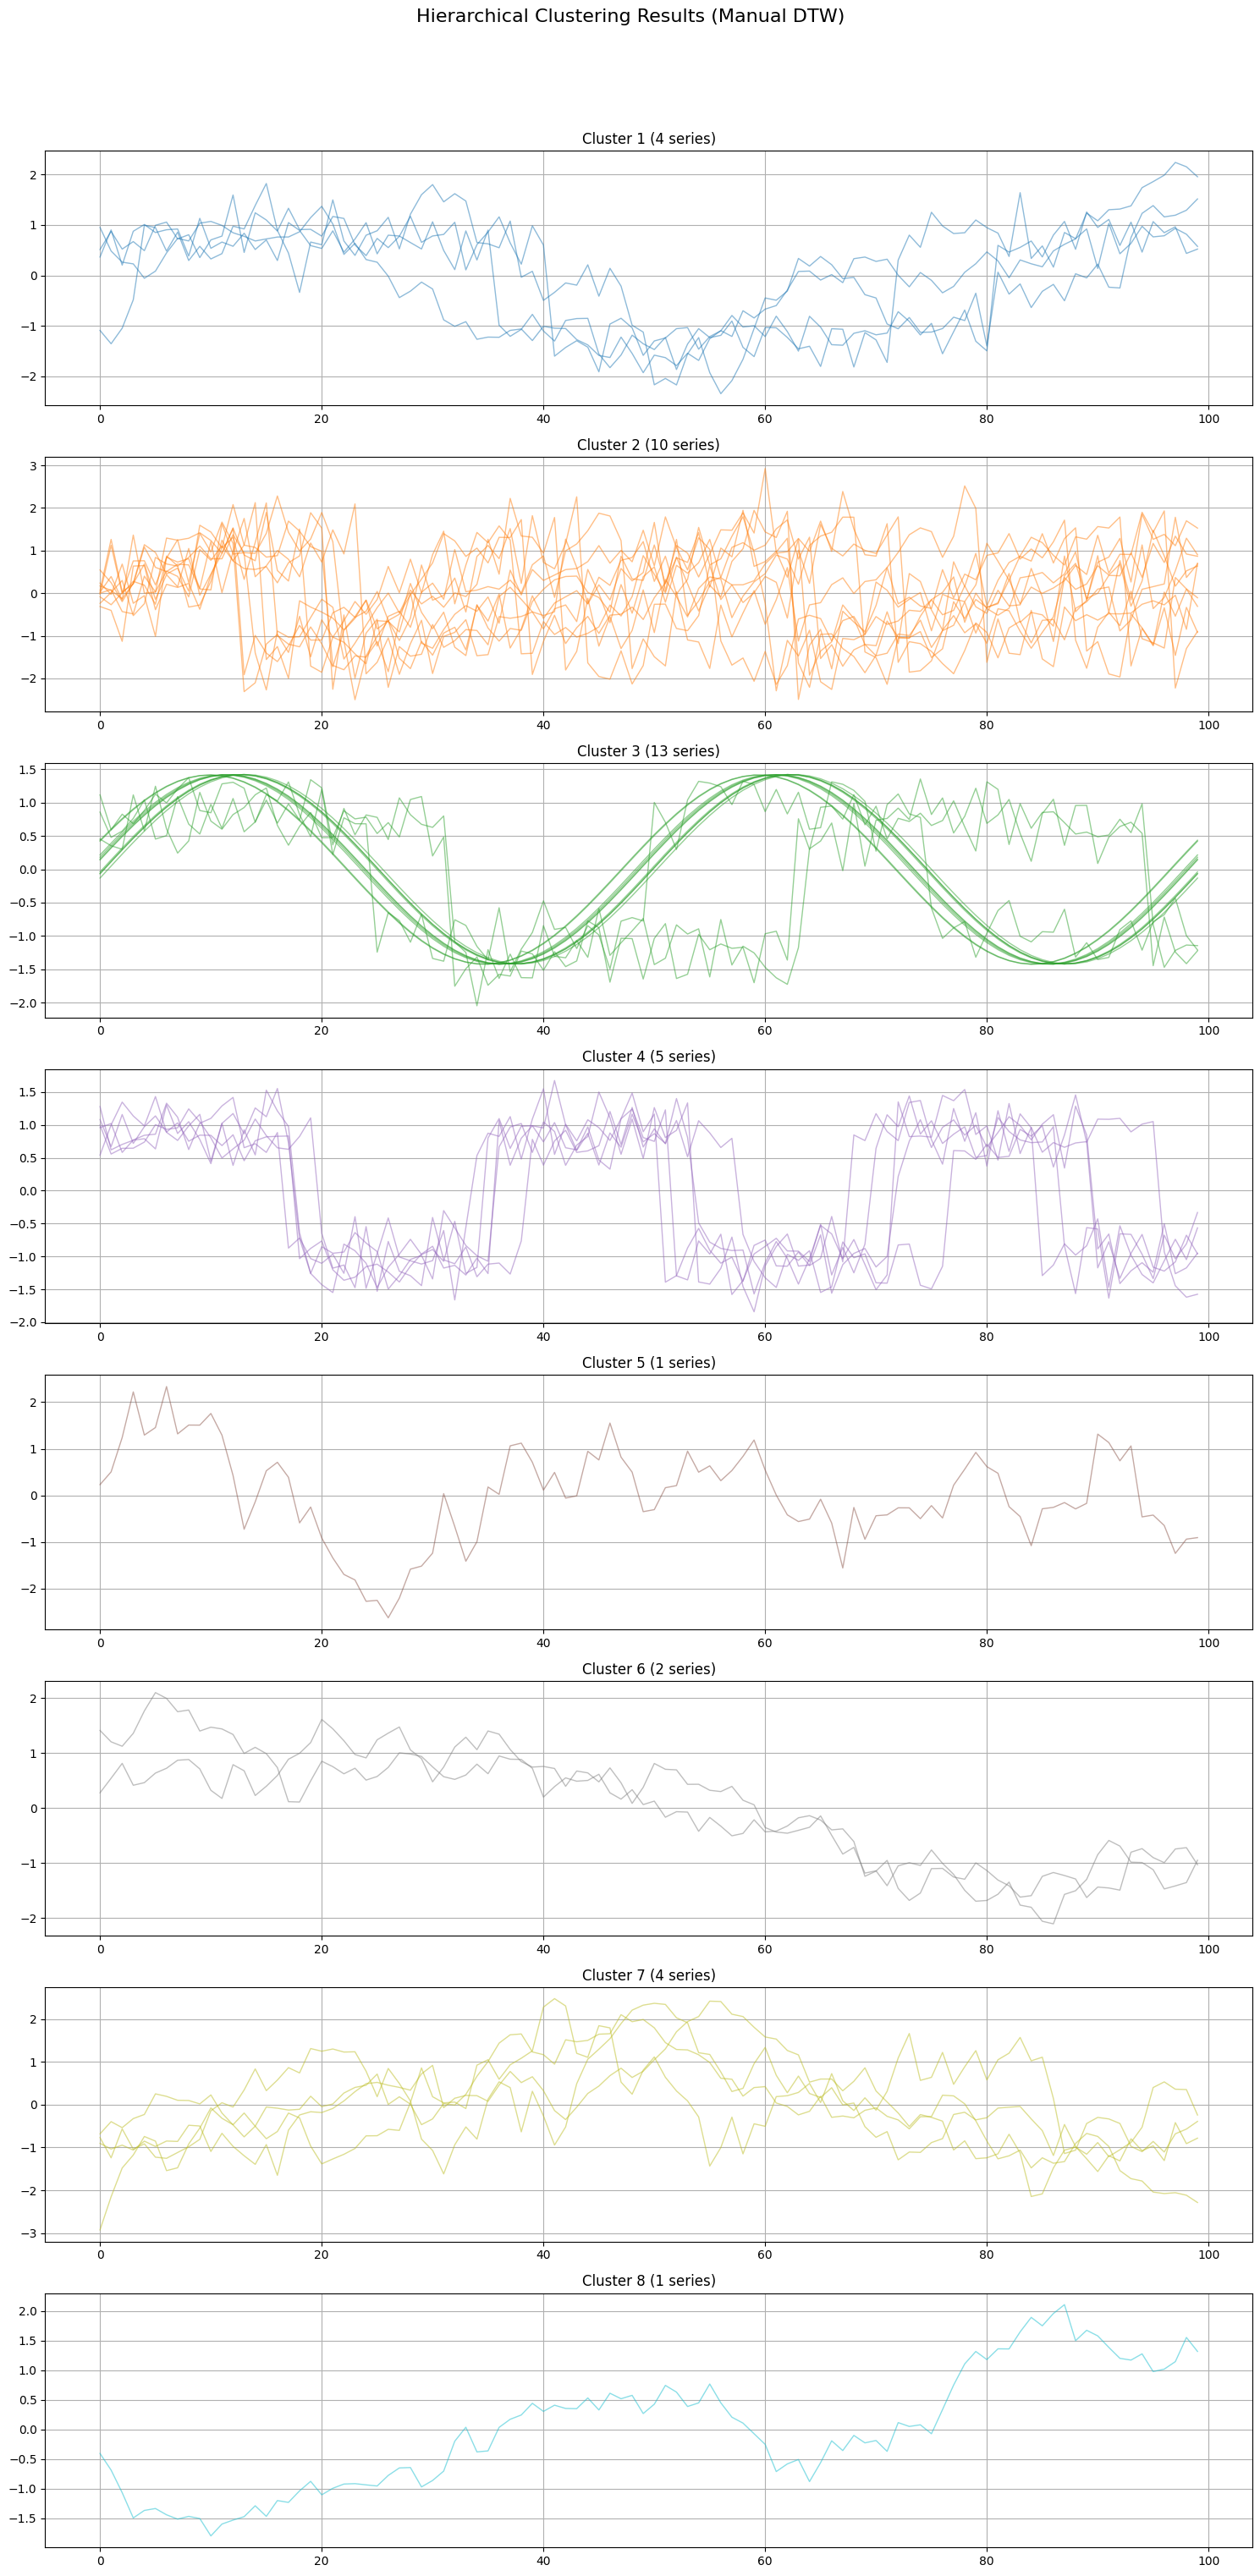

In [19]:
# Visualize clustering results - Hierarchical clustering
print("Visualizing hierarchical clustering results...")
visualize_clusters(
    series_list=series,
    clusters=clusters_hier_manual,
    medoids=None,
    title='Hierarchical Clustering Results (Manual DTW)',
    cmap='tab10'
)

Visualizing K-Medoids clustering results...


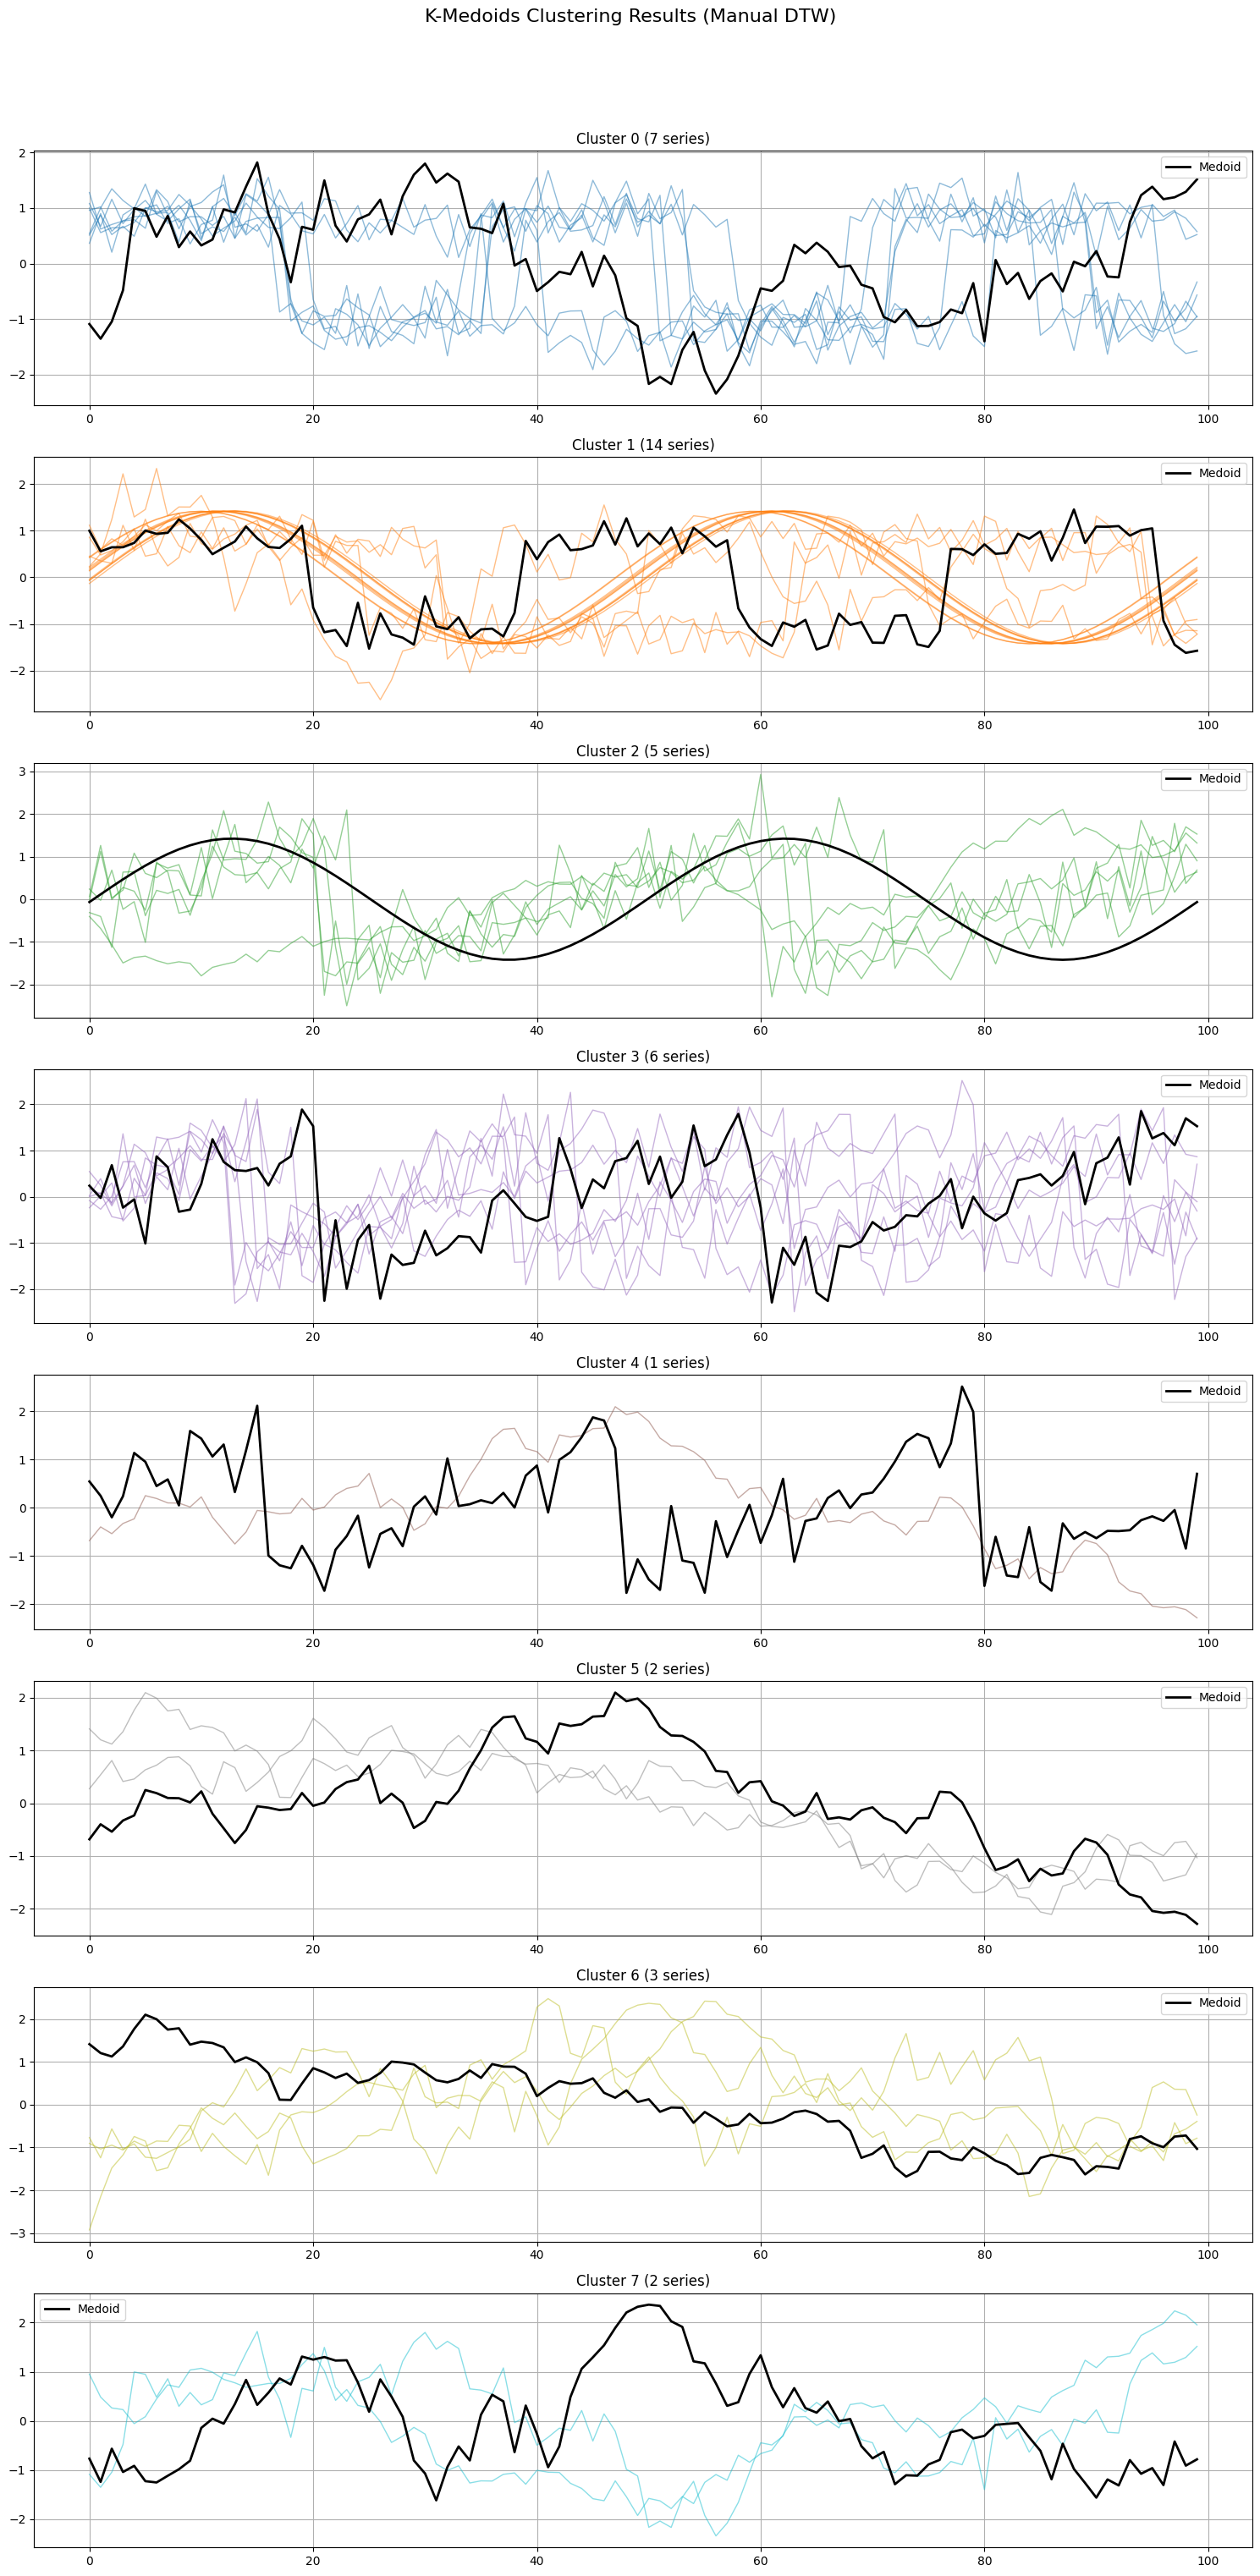

In [20]:
# Visualize clustering results - K-Medoids clustering
print("Visualizing K-Medoids clustering results...")
visualize_clusters(
    series_list=series,
    clusters=clusters_kmed_manual,
    medoids=medoids_manual,
    title='K-Medoids Clustering Results (Manual DTW)',
    cmap='tab10'
)

In [21]:
def apply_dimensionality_reduction(dist_matrix, clusters, method='MDS', title='Dimensionality Reduction Projection'):
    """
    Apply dimensionality reduction techniques for 2D visualization of clusters.

    Parameters:
    - dist_matrix (np.ndarray): Condensed distance matrix.
    - clusters (np.ndarray): Array of cluster labels.
    - method (str): Dimensionality reduction method ('MDS' or 't-SNE').
    - title (str): Title of the plot.

    Returns:
    - None
    """
    square_dist = squareform(dist_matrix)

    if method == 'MDS':
        reducer = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, metric='euclidean', random_state=42, perplexity=30)
    else:
        raise ValueError("Unsupported dimensionality reduction method. Choose 'MDS' or 't-SNE'.")

    embedding = reducer.fit_transform(square_dist)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding[:,0], embedding[:,1], c=clusters, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel(f'{method} Dimension 1')
    plt.ylabel(f'{method} Dimension 2')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.grid(True)
    plt.show()

Applying MDS for 2D visualization of hierarchical clusters...


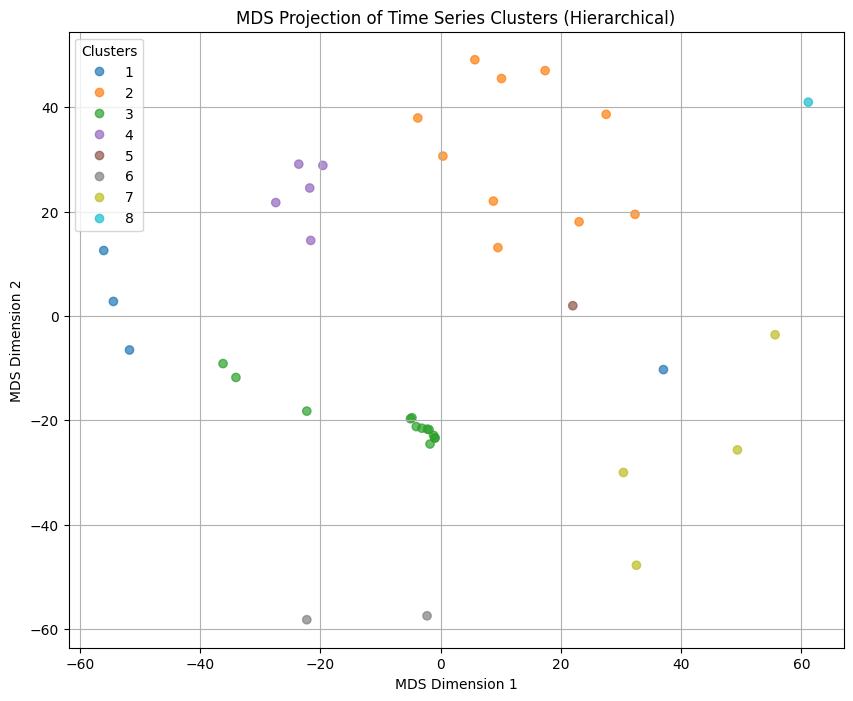

In [22]:
# Dimensionality reduction visualization - Hierarchical clustering
print("Applying MDS for 2D visualization of hierarchical clusters...")
apply_dimensionality_reduction(
    dist_matrix=dist_matrix_manual,
    clusters=clusters_hier_manual,
    method='MDS',
    title='MDS Projection of Time Series Clusters (Hierarchical)'
)

Applying t-SNE for 2D visualization of K-Medoids clusters...


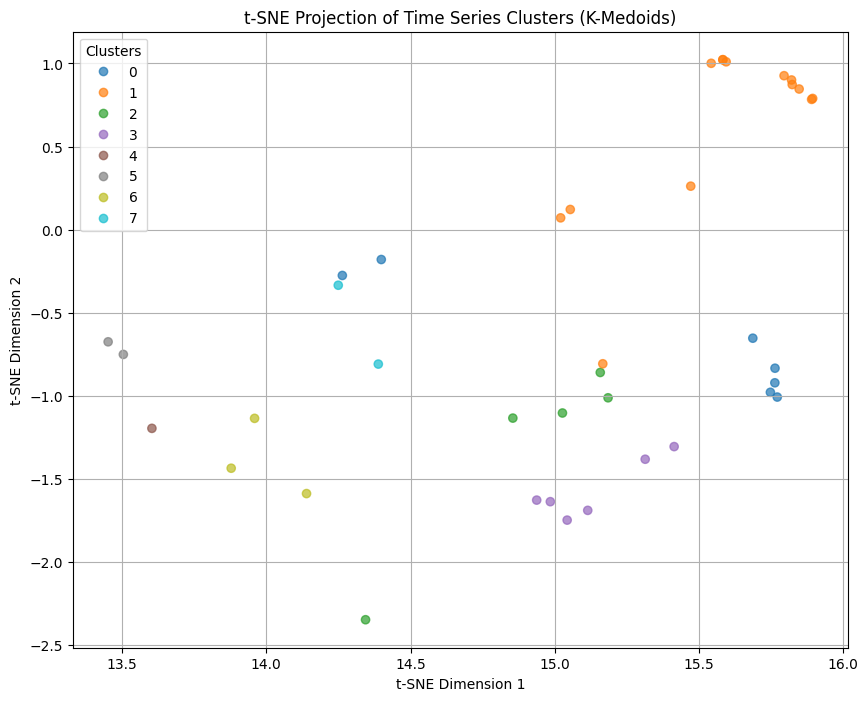

In [23]:
# Dimensionality reduction visualization - K-Medoids clustering
print("Applying t-SNE for 2D visualization of K-Medoids clusters...")
apply_dimensionality_reduction(
    dist_matrix=dist_matrix_manual,
    clusters=clusters_kmed_manual,
    method='t-SNE',
    title='t-SNE Projection of Time Series Clusters (K-Medoids)'
)

# Clustering Metrics

In [24]:
def extract_features(series_list):
    """
    Extract statistical features from time series data.

    Parameters:
    - series_list (list of np.ndarray): List of time series.

    Returns:
    - np.ndarray: 2D array of feature vectors.
    """
    features = []
    for s in series_list:
        mean = np.mean(s)
        std = np.std(s)
        max_val = np.max(s)
        min_val = np.min(s)
        slope = (s[-1] - s[0]) / len(s)
        features.append([mean, std, max_val, min_val, slope])
    return np.array(features)

In [25]:
# Extract features from the time series for cluster validation
features = extract_features(series)

In [26]:
def calculate_cluster_metrics(dist_matrix, clusters, feature_vectors=None, true_labels=None, clustering_method=''):
    """
    Calculate and print cluster validation metrics.

    Parameters:
    - dist_matrix (np.ndarray): Condensed distance matrix.
    - clusters (np.ndarray): Array of cluster labels.
    - feature_vectors (np.ndarray, optional): Feature representations of the time series.
    - true_labels (np.ndarray, optional): Ground truth labels for supervised metrics.
    - clustering_method (str): Name of the clustering method (for display purposes).

    Returns:
    - tuple: Contains calculated metrics in the following order:
        - Silhouette Score
        - Calinski-Harabasz Score (if feature_vectors is provided)
        - Davies-Bouldin Score (if feature_vectors is provided)
        - Adjusted Rand Index (if true_labels is provided)
    """
    # Convert condensed distance matrix to square form
    square_dist = squareform(dist_matrix)

    # Initialize a list to store metric scores
    metrics = []

    # Calculate Silhouette Score
    sil_score = silhouette_score(square_dist, clusters, metric='precomputed')
    print(f"Silhouette Score ({clustering_method}): {sil_score:.4f} (Higher is better)")
    metrics.append(sil_score)

    # Calculate Calinski-Harabasz and Davies-Bouldin Scores if feature_vectors are provided
    if feature_vectors is not None:
        ch_score = calinski_harabasz_score(feature_vectors, clusters)
        db_score = davies_bouldin_score(feature_vectors, clusters)
        print(f"Calinski-Harabasz Score ({clustering_method}): {ch_score:.4f} (Higher is better)")
        print(f"Davies-Bouldin Score ({clustering_method}): {db_score:.4f} (Lower is better)")
        metrics.extend([ch_score, db_score])

    # Calculate Adjusted Rand Index if true_labels are provided
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, clusters)
        print(f"Adjusted Rand Index ({clustering_method}): {ari:.4f} (Higher is better)")
        metrics.append(ari)

    return tuple(metrics)

In [27]:
# Calculate validation metrics for hierarchical clustering
print("Cluster Validation Metrics for Hierarchical Clustering:")
hier_metrics = calculate_cluster_metrics(
    dist_matrix=dist_matrix_manual,
    clusters=clusters_hier_manual,
    feature_vectors=features,
    true_labels=None,
    clustering_method='Hierarchical Clustering'
)

Cluster Validation Metrics for Hierarchical Clustering:
Silhouette Score (Hierarchical Clustering): 0.3813 (Higher is better)
Calinski-Harabasz Score (Hierarchical Clustering): 12.4363 (Higher is better)
Davies-Bouldin Score (Hierarchical Clustering): 3.2599 (Lower is better)


In [28]:
# Calculate validation metrics for K-medoids clustering
print("Cluster Validation Metrics for K-Medoids Clustering:")
kmed_metrics = calculate_cluster_metrics(
    dist_matrix=dist_matrix_manual,
    clusters=clusters_kmed_manual,
    feature_vectors=features,
    true_labels=None,
    clustering_method='K-Medoids Clustering'
)

Cluster Validation Metrics for K-Medoids Clustering:
Silhouette Score (K-Medoids Clustering): 0.3123 (Higher is better)
Calinski-Harabasz Score (K-Medoids Clustering): 6.8013 (Higher is better)
Davies-Bouldin Score (K-Medoids Clustering): 4.0975 (Lower is better)


In [29]:
# Define the metric names
metric_names = ['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']

# Define the clustering methods
methods = ['Hierarchical Clustering', 'K-Medoids Clustering']

# Create the DataFrame
metrics_df = pd.DataFrame([hier_metrics, kmed_metrics], index=methods, columns=metric_names)

# Display the DataFrame
display(metrics_df)

,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
Hierarchical Clustering,0.381311,12.436305,3.259857
K-Medoids Clustering,0.312302,6.801282,4.097482
